## Visualize CTSM-SP simulation forced with NLDAS data over Gothic, CO.
Focus here on input data, espececially:
- potentially low biases in incoming LW
- odd shift in summer incoming shortwave and low maximum values?
- later than expected snow melt
  
Created by Will Wieder, May 2024


In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

## Read in data from simulations
- test3 = SP simulations with 100% PFT1, needleleaf evergreen tree – temperate
- test2_trans, BGC simulations as above
- also ran with a deciduous boreal tree (aspen), but veg died.


In [9]:
# BGC case
exp = 'test3' # 'test2_trans'
fin = '/glade/campaign/cgd/tss/people/wwieder/cheyenne_archive/nldas/gothic/archive/'+exp+'/lnd/hist/'
fin = [fin+exp+'.clm2.h1.2000-01-01-00000.nc', fin+exp+'.clm2.h1.2010-01-01-00000.nc']
dsHr = xr.open_mfdataset(fin, decode_times=True)

<xarray.Dataset>
Dimensions:       (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1,
                   time: 350400, hist_interval: 2, lndgrid: 1)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 1.0
  * time          (time) object 2000-01-01 00:00:00 ... 2019-12-31 23:30:28.1...
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/31)
    mcdate        (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    mcsec         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    mdcur         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    mscur         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    nstep         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    time_bounds   (time, hist_interval) object dask.array<chunksize=(175200, 2), meta=np.ndarray>
    ...            ...
    RAIN          (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    SNOW          (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    SNOW_DEPTH    (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    TBOT          (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(175200, 25, 1), meta=np.ndarray>
    H2OSOI        (time, levsoi, lndgrid) float32 dask.array<chunksize=(175200, 20, 1), meta=np.ndarray>
Attributes: (12/39)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 11/17/23 09:43:09
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     minute_30
    Time_constant_3Dvars_filename:        ./test3.clm2.h1.1980-01-01-00000.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [3]:
exp = 'aspen_sp' 
fin = '/glade/derecho/scratch/wwieder/nldas/ember_1/archive/'+exp+'/lnd/hist/'
fin = [fin+exp+'.clm2.h1.2000-01-01-00000.nc']
dsSP_noLW3 = xr.open_mfdataset(fin, decode_times=True)

In [4]:
exp = 'aspen_sp' 
fin = '/glade/derecho/scratch/wwieder/nldas/gothic/archive/'+exp+'/lnd/hist/'
fin = [fin+exp+'.clm2.h1.2025-01-01-00000.nc']
dsSP = xr.open_mfdataset(fin, decode_times=True)

In [5]:
exp = 'aspen_noLW_sp' 
fin = '/glade/derecho/scratch/wwieder/nldas/gothic/archive/'+exp+'/lnd/hist/'
fin = [fin+exp+'.clm2.h1.2025-01-01-00000.nc']
dsSP_noLW = xr.open_mfdataset(fin, decode_times=True)

In [6]:
exp = 'evergreen_sp'
fin = '/glade/derecho/scratch/wwieder/nldas/gothic/archive/'+exp+'/lnd/hist/'
fin = [fin+exp+'.clm2.h1.1025-01-01-00000.nc']
dsSP2 = xr.open_mfdataset(fin, decode_times=True)

In [8]:
exp = 'evergreen_noLW_sp' 
fin = '/glade/derecho/scratch/wwieder/nldas/gothic/archive/'+exp+'/lnd/hist/'
fin = [fin+exp+'.clm2.h1.1000-01-01-00000.nc']
dsSP2_noLW = xr.open_mfdataset(fin, decode_times=True)

In [10]:
ds = dsHr.resample(time="1D").mean()

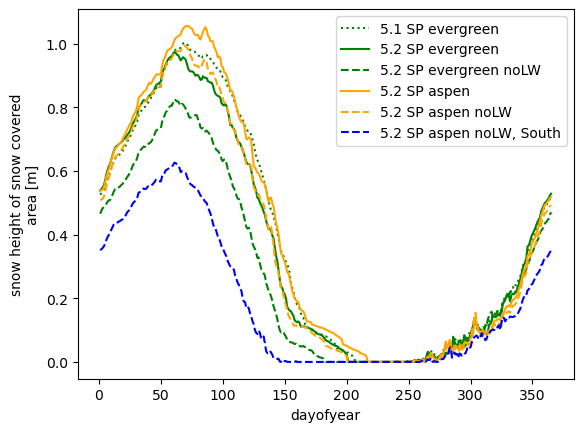

In [11]:
ds.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(label='5.1 SP evergreen',linestyle=':',color='green')
dsSP2.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(label='5.2 SP evergreen',color='green')
dsSP2_noLW.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(label='5.2 SP evergreen noLW',color='green',linestyle='--')
dsSP.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(label='5.2 SP aspen',color='orange')
dsSP_noLW.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(label='5.2 SP aspen noLW',color='orange',linestyle='--')
dsSP_noLW3.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(label='5.2 SP aspen noLW, South',color='blue',linestyle='--')
plt.legend() ;

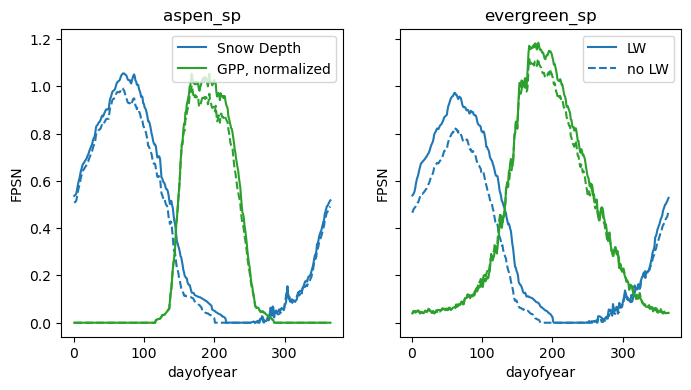

In [12]:
fig, axs = plt.subplots(ncols=2,sharey=True,figsize=(8, 4))

dsSP.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(label='Snow Depth', ax=axs[0])
(dsSP.FPSN.groupby('time.dayofyear').mean().isel(lndgrid=0)/7).plot(label='GPP, normalized', ax=axs[0],color='tab:green')
axs[0].set_ylabel('Snow & GPP*')
axs[0].legend()
dsSP_noLW.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(ax=axs[0],color='tab:orange',linestyle='--')
(dsSP_noLW.FPSN.groupby('time.dayofyear').mean().isel(lndgrid=0)/7).plot(ax=axs[0],color='tab:green',linestyle='--')
axs[0].set_title('aspen_sp')

dsSP2.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(label='LW', ax=axs[1])
dsSP2_noLW.SNOW_DEPTH.groupby('time.dayofyear').mean().isel(lndgrid=0).plot(label='no LW', ax=axs[1],color='tab:blue',linestyle='--')
axs[1].legend()
axs[1].set_ylabel(None)
(dsSP2.FPSN.groupby('time.dayofyear').mean().isel(lndgrid=0)/7).plot(label='GPP, normalized', ax=axs[1],color='tab:green')
(dsSP2_noLW.FPSN.groupby('time.dayofyear').mean().isel(lndgrid=0)/7).plot(ax=axs[1],color='tab:green',linestyle='--')
axs[1].set_title('evergreen_sp') ;

In [7]:
# Look at incoming solar at Gothic (NLDAS) and US-NR1
gothic = '/glade/u/home/wwieder/scratch/nldas/gothic/clmforc.NLDAS2.c2020.TPQWL.gothic.2010-2019.nc'
gothic = xr.open_mfdataset(gothic, decode_times=True).isel(lat=0,lon=0)
gothic2 = '/glade/u/home/wwieder/scratch/nldas/gothic/clmforc.NLDAS2.c2020.Solar.gothic.2010-2019.nc'
gothic2 = xr.open_mfdataset(gothic2, decode_times=True).isel(lat=0,lon=0)
gothic['FSDS']=gothic2['FSDS']
gothic.QBOT

<xarray.DataArray 'QBOT' (time: 87600)>
dask.array<getitem, shape=(87600,), dtype=float32, chunksize=(87600,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2010-01-01 00:00:00 ... 2019-12-31 22:59:52.968750
    lon      float32 253.1
    lat      float32 38.94
Attributes:
    units:      kg/kg
    long_name:  specific humidity at the lowest atm level
    mode:       time-dependent

In [8]:
niwot = '/glade/campaign/cesm/cesmdata/inputdata/atm/datm7/CLM1PT_data/PLUMBER2/US-NR1/CLM1PT_data/CTSM_DATM_US-NR1_1999-2014.nc'
niwot = xr.open_mfdataset(niwot, decode_times=True).isel(lat=0,lon=0)
niwot.QBOT

<xarray.DataArray 'QBOT' (time: 280512)>
dask.array<getitem, shape=(280512,), dtype=float32, chunksize=(280512,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01T07:00:00 ... 2015-01-01T06:30:08
Attributes:
    units:      unitless
    long_name:  relative humidity at the lowest atm level
    mode:       time-dependent

### Average daily shortwave is OK, but longwave seems low

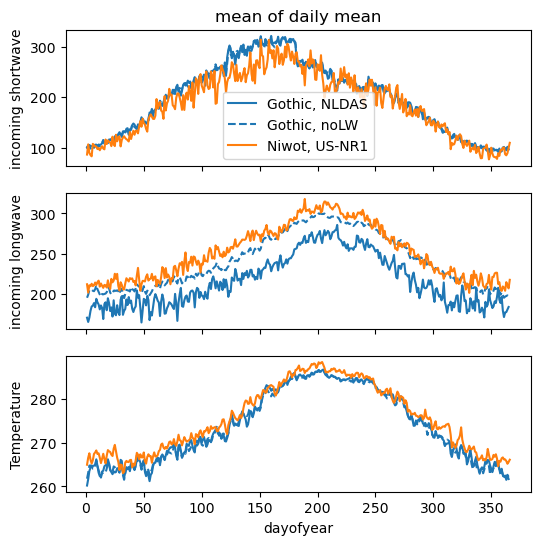

In [9]:
fig, axs = plt.subplots(nrows=3,sharex=True,figsize=(6, 6))
vars = ['FSDS','FLDS','TBOT']
label = ['incoming shortwave', 'incoming longwave', 'Temperature']
for i in range(len(vars)):
    gothic[vars[i]].resample(time="1D").mean().groupby('time.dayofyear').mean().plot(label='Gothic, NLDAS', ax=axs[i])
    dsSP_noLW[vars[i]].resample(time="1D").mean().groupby('time.dayofyear').mean().plot(
        label='Gothic, noLW', ax=axs[i],color='tab:blue',linestyle='--')
    niwot[vars[i]].resample(time="1D").mean().groupby('time.dayofyear').mean().plot(label='Niwot, US-NR1', ax=axs[i])
    axs[i].set_ylabel(label[i])
    if i <= 1: axs[i].set_xlabel(None)
    if i == 0:
        axs[i].legend() ;
        axs[i].set_title('mean of daily mean') ;

### Max daily shortwave is too low?

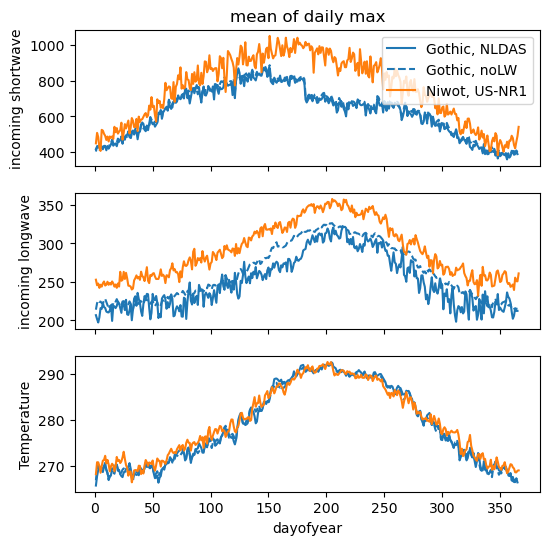

In [10]:
fig, axs = plt.subplots(nrows=3,sharex=True,figsize=(6, 6))
for i in range(len(vars)):
    gothic[vars[i]].resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Gothic, NLDAS', ax=axs[i])
    dsSP_noLW[vars[i]].resample(time="1D").max().groupby('time.dayofyear').mean().plot(
        label='Gothic, noLW', ax=axs[i],color='tab:blue',linestyle='--')
    niwot[vars[i]].resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Niwot, US-NR1', ax=axs[i])
    axs[i].set_ylabel(label[i])
    if i <= 1: axs[i].set_xlabel(None)
    if i == 0:
        axs[i].legend() ;
        axs[i].set_title('mean of daily max') ;


AttributeError: 'IndexVariable' object has no attribute 'hour'

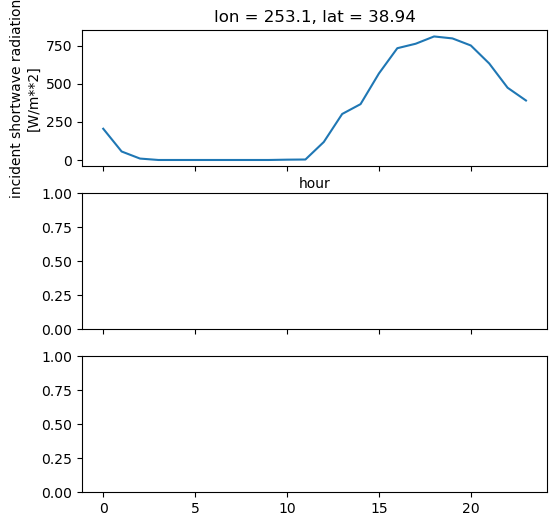

In [11]:
month=5
fig, axs = plt.subplots(nrows=3,sharex=True,figsize=(6, 6))
for i in range(len(vars)):
    gothic[vars[i]].where(gothic['time.month'] == month, drop=True).groupby('time.hour').mean().plot(label='Gothic, NLDAS', ax=axs[i])
    dsSP_noLW[vars[i]].where(gothic['time.month'] == month, drop=True).groupby('time.hour').mean().plot(
        label='Gothic, noLW', ax=axs[i],color='tab:blue',linestyle='--')
    niwot[vars[i]].where(niwot['time.month'] == month, drop=True).groupby('time.hour').mean().plot(label='Niwot, US-NR1', ax=axs[i])
    axs[i].set_ylabel(label[i])
    if i <= 1: axs[i].set_xlabel(None)
    if i == 0:
        axs[i].legend() ;
        axs[i].set_title('May Daily Climo') ;


plt.legend() ;

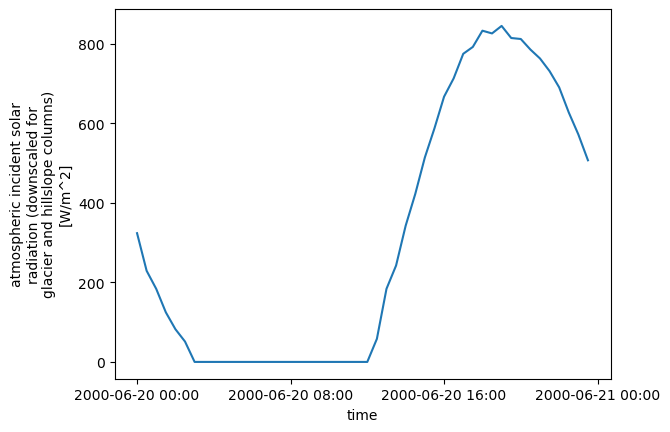

In [74]:
# check daily cycle for alignment of FSDS
sday = 170
gothic[vars[0]].isel(time=slice((48*sday),(48*(sday+1)))).plot()
dsSP_noLW[vars[0]].isel(time=slice((48*sday),(48*(sday+1)))).plot()


---------